In [1]:
# For interactive plots, comment the next line
%pylab inline
# For interactive plots, uncomment the next line
# %pylab ipympl
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Introduction

This notebook demonstrates how to run PODPAC Pipeline on AWS Lambda. Specifically, we will:
* Create a node
* Execute the node on AWS Lambda

**This example requires a pre-configured AWS Lambda node.** We will not cover how the AWS Lambda node was created. For more details see the [AWS Lambda Tutorial](../developer/aws-lambda-tutorial.ipynb). 

<small>*For instructions on using Jupyter notebooks, see the [README.md](../../README.md) file.*</small>

# Setup

Make sure you have PODPAC installed with the **datatype** and **aws** optional dependencies:

```
$ pip install podpac[datatype]
$ pip install podpac[aws]
```

# How to run analysis on AWS Lambda

<i style='font-size:18pt'>PODPAC uses the Python package `boto3` to interact with an S3 bucket which triggers the Lambda function execution. It also uses `boto3` to monitor an S3 bucket for the computed output. </i>


<img src='../Images/PODPAC-AWS-Lambda.png' style='width:80%; margin-left:auto;margin-right:auto' />

# Setup PODPAC for AWS (1/2)

* Configure AWS credentials
* Can be specified at runtime, or in the podpac settings file

In [2]:
import podpac

# Configure AWS Settings
# podpac.settings['S3_BUCKET_NAME'] = '[your-bucket-name]'
# podpac.settings['S3_JSON_FOLDER'] = 'json/'     # Or the S3 folder you'd like JSON to be uploaded to.
# podpac.settings['S3_OUTPUT_FOLDER'] = 'output/' # Or the S3 folder you'd like outputs to be uploaded to.
# podpac.settings['AWS_ACCESS_KEY_ID'] = '[your-access-key]'
# podpac.settings['AWS_SECRET_ACCESS_KEY'] = '[your-access-key-secret]'
# podpac.settings['AWS_REGION_NAME'] = '[your-region]'

## Provide Earth Data Login Credentials
If you do not have an earth data login, or have not activated OpenDAP access, follow the [instructions here](https://creare-com.github.io/podpac-docs/user/earthdata.html).

In [ ]:
import getpass
username = password = None
username = input("Username:");   password = getpass.getpass('Password:')

# Setup (2/2)

* Create the PODPAC Pipeline
* We'll use the same pipeline from the [100-analyzing-SMAP-data.ipynb](100-analyzing-SMAP-data.ipynb) notebook
* This example computes the difference between the current soil moisture for a region, and that of the previous year

In [4]:
import podpac.datalib

# Create the Pipeline
# See 100-analyzing-SMAP-data.ipynb for more details
product = 'SPL4SMAU'   
smap = podpac.datalib.SMAP(product=product, username=username, password=password)
smap_time1_offset = podpac.algorithm.ExpandCoordinates(source=smap, time=['-1,Y', '-1,Y'])
smap_offset = podpac.algorithm.Mean(source=smap_time1_offset, dims=['time'])

# This is the output Node of the Pipeline
diff = podpac.algorithm.Arithmetic(eqn='B-A', A=smap, B=smap_offset)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


# Create PODPAC Coordinates 
* This specifies the region and date where the pipeline will be evaluated

In [5]:
# Specify region of interest on a uniform grid
lat = podpac.crange(  60,  10, -2.0)  # (start, stop, step)
lon = podpac.crange(-130, -60,  2.0)  # (start, stop, step)

# Specify date and time
time = '2018-05-19T12:00:00'

# Create the PODPAC Coordinates
coords = podpac.Coordinates([lat, lon, time], dims=['lat', 'lon', 'time'])

# Evaluating node on AWS cloud 

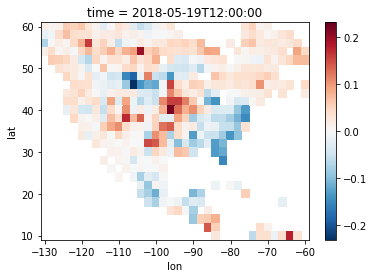

In [7]:
# Set up wrapper to run your node on AWS Lambda
aws = podpac.core.managers.aws_lambda.Lambda(source=diff)   

# Run the node (on AWS Lambda) and get the results back
# (the first time this runs will be slower than subsequent calls)
output = aws.eval(coords)
output.plot()
pass